In [1]:
import importlib
import pandas as pd
import analysis_functions as af
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from scipy.signal import savgol_filter
from scipy import stats
from scipy.io import loadmat
from scipy.ndimage import uniform_filter1d
import os
import pickle
from matplotlib.animation import FuncAnimation
from scipy.ndimage import gaussian_filter1d
from scipy.stats import friedmanchisquare
from scipy.stats import wilcoxon

In [ ]:
# Load the ctl data
desktop_path = os.path.expanduser(r"C:\Users\HAOXUAN YIN\Desktop\behv data\v1_ctldata.pkl")
with open(desktop_path, 'rb') as f:
    data_ctl = pickle.load(f)

# Load the tst data 
desktop_path = os.path.expanduser(r"C:\Users\HAOXUAN YIN\Desktop\behv data\v1_tstdata.pkl")
with open(desktop_path, 'rb') as f:
    data_tst = pickle.load(f)
    data_tst.pop(13)

reward_trigger_ctl_ds = loadmat(r"C:\Users\HAOXUAN YIN\Desktop\behv data\downsampled_rewardtrigger_ctl.mat")
for ani in data_ctl:
    del data_ctl[ani]['reward_indices']
    data_ctl[ani]['reward_indices'] = np.squeeze(reward_trigger_ctl_ds['downsampled_rewardtrigger_ctl'][0][ani])

reward_trigger_tst_ds = loadmat(r"C:\Users\HAOXUAN YIN\Desktop\behv data\downsampled_rewardtrigger_tst.mat")
for ani in data_tst:
    del data_tst[ani]['reward_indices']
    data_tst[ani]['reward_indices'] = np.squeeze(reward_trigger_tst_ds['downsampled_rewardtrigger_tst'][0][ani])

for ani in data_ctl:
    data_ctl[ani]['speed'] = data_ctl[ani]['speed'] - np.percentile(data_ctl[ani]['speed'], 10)  # speed - percentile(speed)
for ani in data_tst:
    data_tst[ani]['speed'] = data_tst[ani]['speed'] - np.percentile(data_tst[ani]['speed'], 10)  # speed - percentile(speed)



In [3]:
# Load data
desktop_path = os.path.expanduser(r"C:\Users\HAOXUAN YIN\Desktop\v1ctldata_full.pkl")
with open(desktop_path, 'rb') as f:
    data = pickle.load(f)

# downsample from 1000fps to 10fps
for ani in data:
    data[ani]['grating_indices']['gr_1'] = np.array(data[ani]['grating_indices']['gr_1'])//100
    data[ani]['grating_indices']['gr_2'] = np.array(data[ani]['grating_indices']['gr_2'])//100
    data[ani]['trial_start_indices'] = np.array(data[ani]['trial_start_indices'])//100
    data[ani]['reward_indices'] = np.array(data[ani]['reward_indices'])//100

# downsample the position data by calculating the average every 100 frames
    num_groups = data[ani]['position'].shape[0] // 100
    data[ani]['position'] = data[ani]['position'].reshape(num_groups, 100).mean(axis=1) # Reshape and compute the mean of every 100-frame chunk

# downsample the speed data
    num_groups = data[ani]['speed'].shape[0] // 100
    data[ani]['speed'] = data[ani]['speed'].reshape(num_groups, 100).mean(axis=1) # Reshape and compute the mean of every 100-frame chunk

# speed data
    # data[ani]['speed'] = (data[ani]['speed'] - np.nanmedian(data[ani]['speed']))/ np.std(data[ani]['speed'])     # speed - median(speed)  session level
    data[ani]['speed'] = data[ani]['speed'] - np.percentile(data[ani]['speed'], 10)  # speed - percentile(speed)
    
    # trials = []
    # for i in range(len(data[ani]['trial_start_indices'])-1):
    #     trials.append([data[ani]['trial_start_indices'][i], data[ani]['trial_start_indices'][i+1]])
    # for trial in trials:
    #     data[ani]['speed'][trial] = data[ani]['speed'][trial] - np.nanmedian(data[ani]['speed'][trial])   # speed - median(speed)  trial level
    #     data[ani]['speed'][trial] = data[ani]['speed'][trial] - np.percentile(data[ani]['speed'][trial],20)  # speed - percentile(speed)

# smooth the data
    data[ani]['speed'] = gaussian_filter1d(data[ani]['speed'], sigma=1, axis=0) 

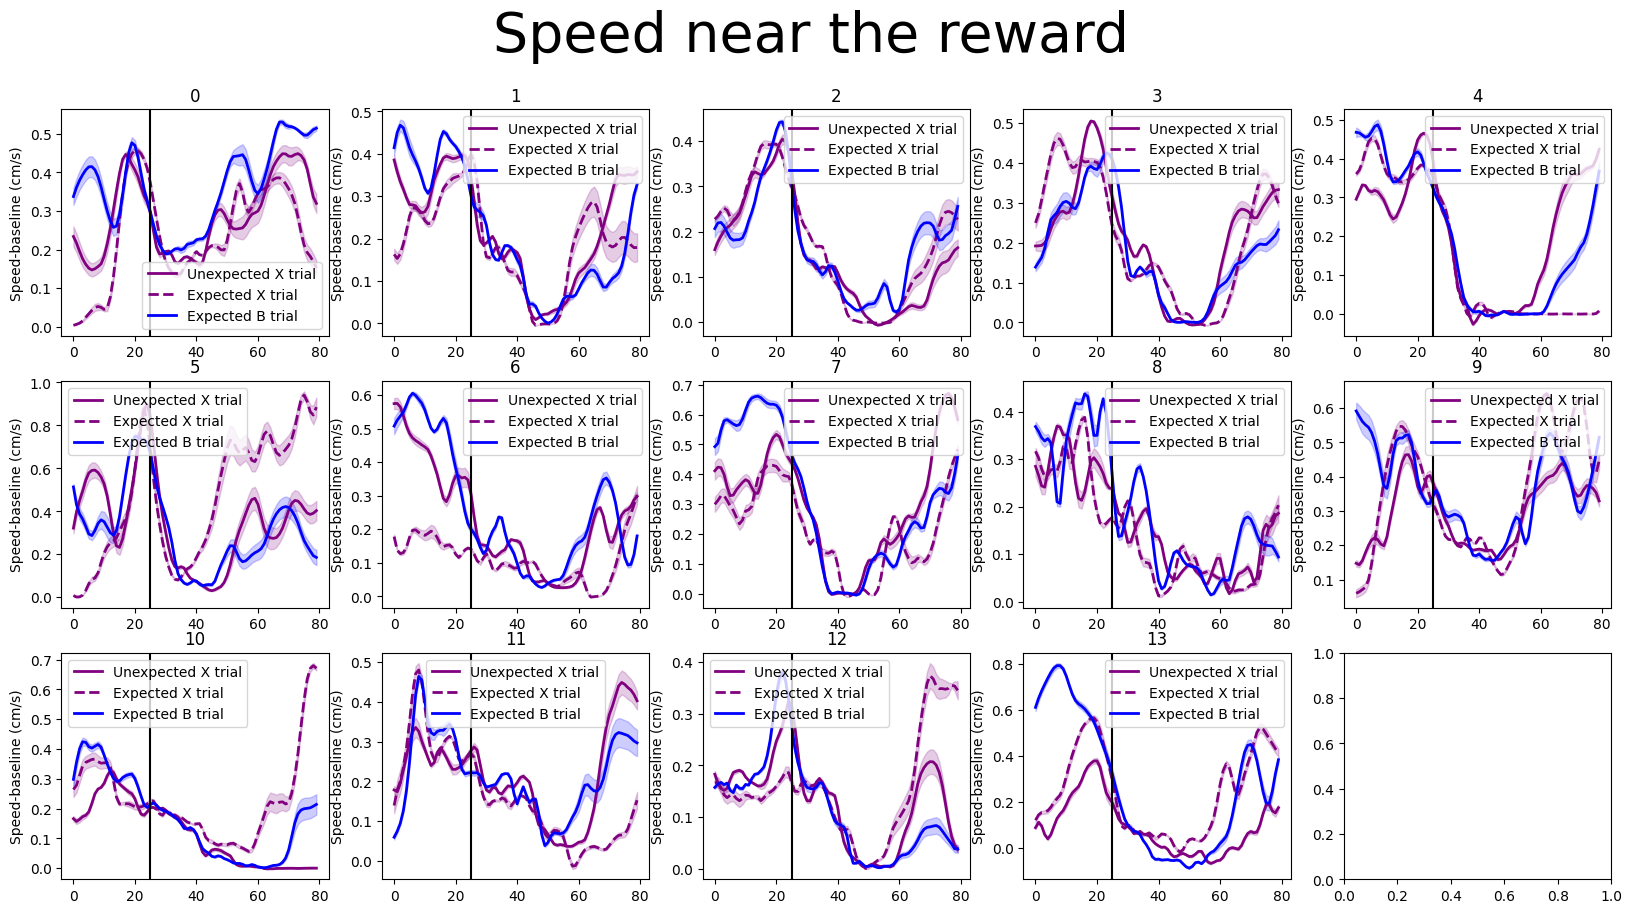

In [23]:
# SPEED NEAR THE REWARD FOR EACH ANIMAL

unexp_rw = {}
exp_rw = {}
for ani in data:
    unexp_rw[ani] = []
    exp_rw[ani] = []
    for trial in data[ani]['unpred_trials']['gr_2']:
        if trial < data[ani]['reward_indices'].shape[0]:    # index out of range,,, so
            unexp_rw[ani].append(range(data[ani]['reward_indices'][trial]-25,data[ani]['reward_indices'][trial]+55)) 
    for trial in data[ani]['unpred_trials']['gr_2']:
        if trial < data[ani]['reward_indices'].shape[0]:
            exp_rw[ani].append(range(data[ani]['reward_indices'][trial-1]-25,data[ani]['reward_indices'][trial-1]+55))

fig, axes = plt.subplots(3, 5, figsize=(20, 10)) 
fig.suptitle('Speed near the reward', fontsize = 40)
t_frames = range(80)
for i, ani in enumerate(data):
    row = i // 5
    col = i % 5
    ax = axes[row, col]
    af.plot_shaded_error(ax, t_frames, data[ani]['speed'][np.array(unexp_rw[ani][:4])], color='purple', alpha=0.2, label='Unexpected X trial')
    af.plot_shaded_error(ax, t_frames, data[ani]['speed'][np.array(unexp_rw[ani][6:10])], color='purple', alpha=0.2, style='dash', label='Expected X trial')
    af.plot_shaded_error(ax, t_frames, data[ani]['speed'][np.array(exp_rw[ani][:4])], color='blue', alpha=0.2, label= 'Expected B trial')
    ax.axvline([25], color='black')
    ax.set_ylabel('Speed-baseline (cm/s)')
    ax.set_title(f'{ani}')
    ax.legend()

In [43]:
unexp_tri = slice(0,6)
unexp_tri_late = slice(6,12)
exp_tri = slice(0,6)

In [44]:
# Subselect animals based on average acceleration 1s prior to the reward

acc_group = [] # speed up before reward
dec_group = [] # slow down before reward

for ani in data:
    avg_acc_unexp_X = np.mean(np.mean(np.gradient(data[ani]['speed'][unexp_rw[ani][unexp_tri]][:,15:25], axis=1),axis=1),axis=0)
    avg_acc_exp_X = np.mean(np.mean(np.gradient(data[ani]['speed'][unexp_rw[ani][unexp_tri_late]][:,15:25], axis=1),axis=1),axis=0)
    avg_acc_exp_B = np.mean(np.mean(np.gradient(data[ani]['speed'][exp_rw[ani][exp_tri]][:,15:25], axis=1),axis=1),axis=0)
    if avg_acc_unexp_X+avg_acc_exp_X+avg_acc_exp_B >= 0:
        acc_group.append(ani)
    else:
        dec_group.append(ani)

print('Acc_group:', acc_group)
print('Dec_group:', dec_group)

Acc_group: [0, 1, 2, 4, 5, 12]
Dec_group: [3, 6, 7, 8, 9, 10, 11, 13]


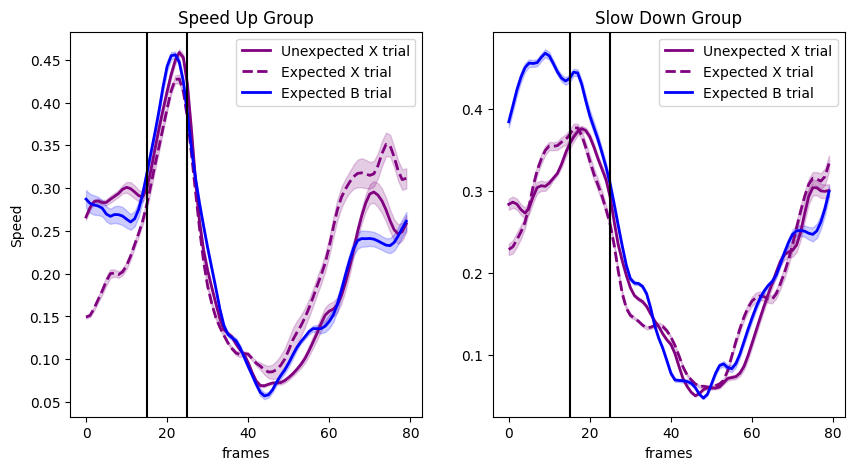

In [46]:
# SPEED PRIOR TO THE REWARD AVERAGED OVER TWO GROUPS

fig, axes = plt.subplots(1,2,figsize=(10, 5)) 
af.plot_shaded_error(axes[0], range(80), np.mean(np.stack([data[ani]['speed'][np.array(unexp_rw[ani][unexp_tri])] for ani in acc_group]), axis = 0), color='purple', alpha=0.2, label='Unexpected X trial')
af.plot_shaded_error(axes[0], range(80), np.mean(np.stack([data[ani]['speed'][np.array(unexp_rw[ani][unexp_tri_late])] for ani in acc_group]), axis = 0), color='purple', alpha=0.2, style='dash', label='Expected X trial')
af.plot_shaded_error(axes[0], range(80), np.mean(np.stack([data[ani]['speed'][np.array(exp_rw[ani][exp_tri])] for ani in acc_group]), axis = 0), color='blue', alpha=0.2, label= 'Expected B trial')
axes[0].set_title('Speed Up Group')
axes[0].set_xlabel('frames')
axes[0].set_ylabel('Speed')
axes[0].axvline([15], color='black')
axes[0].axvline([25], color='black')

af.plot_shaded_error(axes[1], range(80), np.mean(np.stack([data[ani]['speed'][np.array(unexp_rw[ani][unexp_tri])] for ani in dec_group]), axis = 0), color='purple', alpha=0.2, label='Unexpected X trial')
af.plot_shaded_error(axes[1], range(80), np.mean(np.stack([data[ani]['speed'][np.array(unexp_rw[ani][unexp_tri_late])] for ani in dec_group]), axis = 0), color='purple', alpha=0.2, style='dash', label='Expected X trial')
af.plot_shaded_error(axes[1], range(80), np.mean(np.stack([data[ani]['speed'][np.array(exp_rw[ani][exp_tri])] for ani in dec_group]), axis = 0), color='blue', alpha=0.2, label= 'Expected B trial')
axes[1].set_title('Slow Down Group')
axes[1].set_xlabel('frames')
axes[1].axvline([15], color='black')  
axes[1].axvline([25], color='black')

Text(0.5, 0, 'frames')

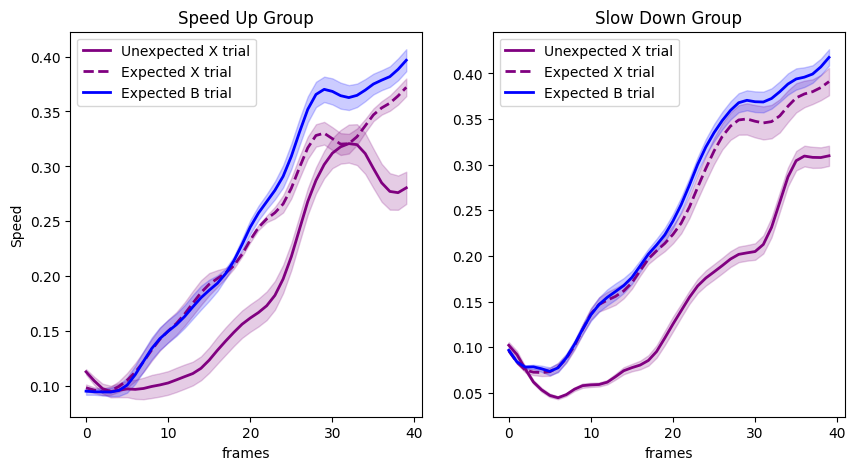

In [7]:
# SPEED AFTER THE REWARD AVERAGED OVER TWO GROUPS

t_frames = range(40)
fig, axes = plt.subplots(1,2,figsize=(10, 5)) 
af.plot_shaded_error(axes[0], t_frames, np.mean(np.stack([data[ani]['speed'][np.array(unexp_rw[ani][:7])][:,40:] for ani in acc_group]), axis = 0), color='purple', alpha=0.2, label='Unexpected X trial')
af.plot_shaded_error(axes[0], t_frames, np.mean(np.stack([data[ani]['speed'][np.array(unexp_rw[ani][20:27])][:,40:] for ani in acc_group]), axis = 0), color='purple', alpha=0.2, style='dash', label='Expected X trial')
af.plot_shaded_error(axes[0], t_frames, np.mean(np.stack([data[ani]['speed'][np.array(exp_rw[ani][20:27])][:,40:] for ani in acc_group]), axis = 0), color='blue', alpha=0.2, label= 'Expected B trial')
axes[0].set_title('Speed Up Group')
axes[0].set_xlabel('frames')
axes[0].set_ylabel('Speed')

af.plot_shaded_error(axes[1], t_frames, np.mean(np.stack([data[ani]['speed'][np.array(unexp_rw[ani][:7])][:,40:] for ani in dec_group]), axis = 0), color='purple', alpha=0.2, label='Unexpected X trial')
af.plot_shaded_error(axes[1], t_frames, np.mean(np.stack([data[ani]['speed'][np.array(unexp_rw[ani][20:27])][:,40:] for ani in dec_group]), axis = 0), color='purple', alpha=0.2, style='dash', label='Expected X trial')
af.plot_shaded_error(axes[1], t_frames, np.mean(np.stack([data[ani]['speed'][np.array(exp_rw[ani][20:27])][:,40:] for ani in dec_group]), axis = 0), color='blue', alpha=0.2, label= 'Expected B trial')
axes[1].set_title('Slow Down Group')
axes[1].set_xlabel('frames')


In [8]:
results = []
for ani in acc_group:
    # slice the data
    exp_B_data = data[ani]['speed'][exp_rw[ani][7:14]][:,45:]
    unexp_X_data = data[ani]['speed'][unexp_rw[ani][:7]][:,45:]
    exp_X_data = data[ani]['speed'][unexp_rw[ani][20:27]][:,45:]
    # average across trials to get a single mean trace for each condition
    exp_B_trace = exp_B_data.mean(axis=0)        # shape = timepoints
    unexp_X_trace = unexp_X_data.mean(axis=0)
    exp_X_trace = exp_X_data.mean(axis=0)

    # plt.plot(exp_B_trace)
    # plt.plot(unexp_X_trace)
    # plt.plot(exp_X_trace)
    # area under the mean trace (AUC)
    # x-axis is frame index (0…N-1) so we can just use np.arange
    frames = np.arange(exp_B_trace.shape[0])
    auc_exp_B     = np.trapz(exp_B_trace,     frames)
    auc_unexp_X   = np.trapz(unexp_X_trace,   frames)
    auc_exp_X     = np.trapz(exp_X_trace,     frames)

    print(auc_unexp_X)

for ani in dec_group:
    # slice the data
    exp_B_data = data[ani]['speed'][exp_rw[ani][7:14]][:,45:]
    unexp_X_data = data[ani]['speed'][unexp_rw[ani][:7]][:,45:]
    exp_X_data = data[ani]['speed'][unexp_rw[ani][20:27]][:,45:]
    # average across trials to get a single mean trace for each condition
    exp_B_trace = exp_B_data.mean(axis=0)        # shape = timepoints
    unexp_X_trace = unexp_X_data.mean(axis=0)
    exp_X_trace = exp_X_data.mean(axis=0)

    # plt.plot(exp_B_trace)
    # plt.plot(unexp_X_trace)
    # plt.plot(exp_X_trace)
    # area under the mean trace (AUC)
    # x-axis is frame index (0…N-1) so we can just use np.arange
    frames = np.arange(exp_B_trace.shape[0])
    auc_exp_B     = np.trapz(exp_B_trace,     frames)
    auc_unexp_X   = np.trapz(unexp_X_trace,   frames)
    auc_exp_X     = np.trapz(exp_X_trace,     frames)

    print(auc_unexp_X)

12.653673299069148
6.700332114418822
3.1215359150707105
3.4745194737543774
13.978009259796115
4.83534709645104
2.4934624157666643
4.127494655984821
3.489880999738898
8.579380429433225
2.7517366905579266
12.524294412480812
3.052184822760475
2.673458269427107


Text(0, 0.5, 'Speed (z-score)')

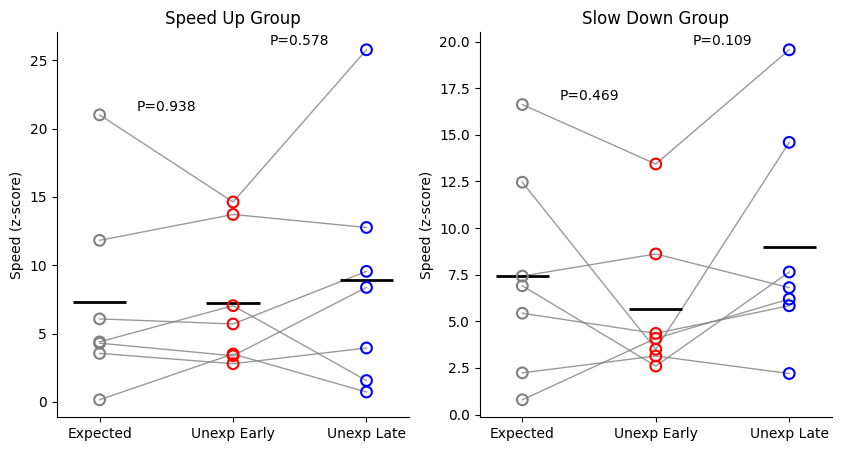

In [9]:
# AUC after reward

fig, ax = plt.subplots(1,2,figsize=(10,5))

results = []
for ani in acc_group:
    # slice the data
    exp_B_data = data[ani]['speed'][exp_rw[ani][7:14]][:,40:]
    unexp_X_data = data[ani]['speed'][unexp_rw[ani][:7]][:,40:]
    exp_X_data = data[ani]['speed'][unexp_rw[ani][20:27]][:,40:]
    # average across trials to get a single mean trace for each condition
    exp_B_trace = exp_B_data.mean(axis=0)        # shape = timepoints
    unexp_X_trace = unexp_X_data.mean(axis=0)
    exp_X_trace = exp_X_data.mean(axis=0)
    # area under the mean trace (AUC)
    frames = np.arange(exp_B_trace.shape[0])
    auc_exp_B     = np.trapz(exp_B_trace,     frames)
    auc_unexp_X   = np.trapz(unexp_X_trace,   frames)
    auc_exp_X     = np.trapz(exp_X_trace,     frames)
    results.append([auc_exp_B, auc_unexp_X, auc_exp_X])


results = np.array(results)   # shape = (n_animals, 3)
colors = ['gray', 'red', 'blue']
x_positions = [1,2,3]
for i, xpos in enumerate(x_positions):
    ax[0].scatter(np.full(results.shape[0], xpos), results[:, i], facecolors='none', edgecolors=colors[i], s=60, linewidth=1.5, zorder=3) # Plot scatter points for each animal
for animal in results:
    ax[0].plot(x_positions, animal, color='gray', linewidth=1, alpha=0.8, zorder=2) # Connect each animal's points with a line
for i in range(results.shape[1]):
    mean_val = np.mean(results[:, i])
    ax[0].hlines(mean_val, i+0.8, i+1.2, colors=colors[i], linewidth=2, color = 'black') # Plot mean horizontal lines
# ax[0].set_ylim([-0.5,3.5])
ax[0].set_xticks([1, 2, 3])
ax[0].set_xticklabels(['Expected', 'Unexp Early', 'Unexp Late'])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
# pairwise test
pairs = [(0,1), (0,2), (1,2)]
labels = ["Expected vs Unexp Early", "Expected vs Unexp Late", "Unexp Early vs Unexp Late"]
pvals = []
for (i,j), label in zip(pairs, labels):
    stat, p = wilcoxon(results[:,i], results[:,j])
    pvals.append(p)
# Add p value bar
i, j = 0, 1 
x = (i+1 + j+1) / 2 
y = max(results[:,i].max(), results[:,j].max()) + 0.1
ax[0].text(x, y, f"P={pvals[0]:.3f}", ha='center', va='bottom')
i, j = 1, 2 
x = (i+1 + j+1) / 2 
y = max(results[:,i].max(), results[:,j].max()) + 0.1  
ax[0].text(x, y, f"P={pvals[2]:.3f}", ha='center', va='bottom')
ax[0].set_title('Speed Up Group')
ax[0].set_ylabel("Speed (z-score)")


results = []
for ani in dec_group:
    # slice the data
    exp_B_data = data[ani]['speed'][exp_rw[ani][7:14]][:,40:]
    unexp_X_data = data[ani]['speed'][unexp_rw[ani][:7]][:,40:]
    exp_X_data = data[ani]['speed'][unexp_rw[ani][20:27]][:,40:]
    # average across trials to get a single mean trace for each condition
    exp_B_trace = exp_B_data.mean(axis=0)        # shape = timepoints
    unexp_X_trace = unexp_X_data.mean(axis=0)
    exp_X_trace = exp_X_data.mean(axis=0)
    # area under the mean trace (AUC)
    frames = np.arange(exp_B_trace.shape[0])
    auc_exp_B     = np.trapz(exp_B_trace,     frames)
    auc_unexp_X   = np.trapz(unexp_X_trace,   frames)
    auc_exp_X     = np.trapz(exp_X_trace,     frames)
    results.append([auc_exp_B, auc_unexp_X, auc_exp_X])


results = np.array(results)   # shape = (n_animals, 3)
colors = ['gray', 'red', 'blue']
x_positions = [1,2,3]
for i, xpos in enumerate(x_positions):
    ax[1].scatter(np.full(results.shape[0], xpos), results[:, i], facecolors='none', edgecolors=colors[i], s=60, linewidth=1.5, zorder=3) # Plot scatter points for each animal
for animal in results:
    ax[1].plot(x_positions, animal, color='gray', linewidth=1, alpha=0.8, zorder=2) # Connect each animal's points with a line
for i in range(results.shape[1]):
    mean_val = np.mean(results[:, i])
    ax[1].hlines(mean_val, i+0.8, i+1.2, colors=colors[i], linewidth=2, color = 'black') # Plot mean horizontal lines
# ax[0].set_ylim([-0.5,3.5])
ax[1].set_xticks([1, 2, 3])
ax[1].set_xticklabels(['Expected', 'Unexp Early', 'Unexp Late'])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
# pairwise test
pairs = [(0,1), (0,2), (1,2)]
labels = ["Expected vs Unexp Early", "Expected vs Unexp Late", "Unexp Early vs Unexp Late"]
pvals = []
for (i,j), label in zip(pairs, labels):
    stat, p = wilcoxon(results[:,i], results[:,j])
    pvals.append(p)
# Add p value bar
i, j = 0, 1 
x = (i+1 + j+1) / 2 
y = max(results[:,i].max(), results[:,j].max()) + 0.1
ax[1].text(x, y, f"P={pvals[0]:.3f}", ha='center', va='bottom')
i, j = 1, 2 
x = (i+1 + j+1) / 2 
y = max(results[:,i].max(), results[:,j].max()) + 0.1  
ax[1].text(x, y, f"P={pvals[2]:.3f}", ha='center', va='bottom')
ax[1].set_title('Slow Down Group')
ax[1].set_ylabel("Speed (z-score)")


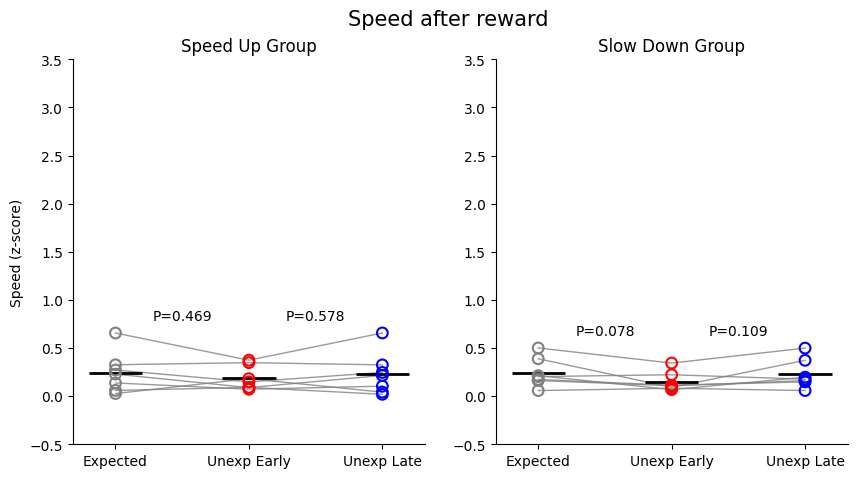

In [10]:
# Average speed after reward


results = []  # each item in the result is [expected, unexpected_early, unexpected_late]
for ani in acc_group:
    avg_speed_exp_B = np.mean(np.mean(data[ani]['speed'][exp_rw[ani][20:27]][:,40:],axis=0),axis=0)
    avg_speed_unexp_X = np.mean(np.mean(data[ani]['speed'][unexp_rw[ani][:7]][:,40:],axis=0),axis=0)
    avg_speed_exp_X = np.mean(np.mean(data[ani]['speed'][unexp_rw[ani][20:27]][:,40:],axis=0),axis=0)
    results.append([avg_speed_exp_B, avg_speed_unexp_X, avg_speed_exp_X])
results = np.array(results)   # shape = (n_animals, 3)
colors = ['gray', 'red', 'blue']
x_positions = [1,2,3]
fig, ax = plt.subplots(1,2,figsize=(10,5))
for i, xpos in enumerate(x_positions):
    ax[0].scatter(np.full(results.shape[0], xpos), results[:, i], facecolors='none', edgecolors=colors[i], s=60, linewidth=1.5, zorder=3) # Plot scatter points for each animal
for animal in results:
    ax[0].plot(x_positions, animal, color='gray', linewidth=1, alpha=0.8, zorder=2) # Connect each animal's points with a line
for i in range(results.shape[1]):
    mean_val = np.mean(results[:, i])
    ax[0].hlines(mean_val, i+0.8, i+1.2, colors=colors[i], linewidth=2, color = 'black') # Plot mean horizontal lines
ax[0].set_ylim([-0.5,3.5])
ax[0].set_xticks([1, 2, 3])
ax[0].set_xticklabels(['Expected', 'Unexp Early', 'Unexp Late'])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
# pairwise test
pairs = [(0,1), (0,2), (1,2)]
labels = ["Expected vs Unexp Early", "Expected vs Unexp Late", "Unexp Early vs Unexp Late"]
pvals = []
for (i,j), label in zip(pairs, labels):
    stat, p = wilcoxon(results[:,i], results[:,j])
    pvals.append(p)
# Add p value bar
i, j = 0, 1 
x = (i+1 + j+1) / 2 
y = max(results[:,i].max(), results[:,j].max()) + 0.1
ax[0].text(x, y, f"P={pvals[0]:.3f}", ha='center', va='bottom')
i, j = 1, 2 
x = (i+1 + j+1) / 2 
y = max(results[:,i].max(), results[:,j].max()) + 0.1  
ax[0].text(x, y, f"P={pvals[2]:.3f}", ha='center', va='bottom')
ax[0].set_title('Speed Up Group')
ax[0].set_ylabel("Speed (z-score)")


results = []  # each item in the result is [expected, unexpected_early, unexpected_late]
for ani in dec_group:
    avg_speed_exp_B = np.mean(np.mean(data[ani]['speed'][exp_rw[ani][20:27]][:,40:],axis=0),axis=0)
    avg_speed_unexp_X = np.mean(np.mean(data[ani]['speed'][unexp_rw[ani][:7]][:,40:],axis=0),axis=0)
    avg_speed_exp_X = np.mean(np.mean(data[ani]['speed'][unexp_rw[ani][20:27]][:,40:],axis=0),axis=0)
    results.append([avg_speed_exp_B, avg_speed_unexp_X, avg_speed_exp_X])
results = np.array(results)   # shape = (n_animals, 3)
colors = ['gray', 'red', 'blue']
x_positions = [1,2,3]
for i, xpos in enumerate(x_positions):
    ax[1].scatter(np.full(results.shape[0], xpos), results[:, i], facecolors='none', edgecolors=colors[i], s=60, linewidth=1.5, zorder=3) # Plot scatter points for each animal
for animal in results:
    ax[1].plot(x_positions, animal, color='gray', linewidth=1, alpha=0.8, zorder=2) # Connect each animal's points with a line
for i in range(results.shape[1]):
    mean_val = np.mean(results[:, i])
    ax[1].hlines(mean_val, i+0.8, i+1.2, colors=colors[i], linewidth=2, color = 'black') # Plot mean horizontal lines
ax[1].set_ylim([-0.5,3.5])
ax[1].set_xticks([1, 2, 3])
ax[1].set_xticklabels(['Expected', 'Unexp Early', 'Unexp Late'])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
# pairwise test
pairs = [(0,1), (0,2), (1,2)]
labels = ["Expected vs Unexp Early", "Expected vs Unexp Late", "Unexp Early vs Unexp Late"]
pvals = []
for (i,j), label in zip(pairs, labels):
    stat, p = wilcoxon(results[:,i], results[:,j])
    pvals.append(p)
# Add p value bar
i, j = 0, 1 
x = (i+1 + j+1) / 2 
y = max(results[:,i].max(), results[:,j].max()) + 0.1
ax[1].text(x, y, f"P={pvals[0]:.3f}", ha='center', va='bottom')
i, j = 1, 2 
x = (i+1 + j+1) / 2 
y = max(results[:,i].max(), results[:,j].max()) + 0.1  
ax[1].text(x, y, f"P={pvals[2]:.3f}", ha='center', va='bottom')
ax[1].set_title('Slow Down Group')

fig.suptitle('Speed after reward', fontsize = 15)
plt.tight_layout
plt.show()

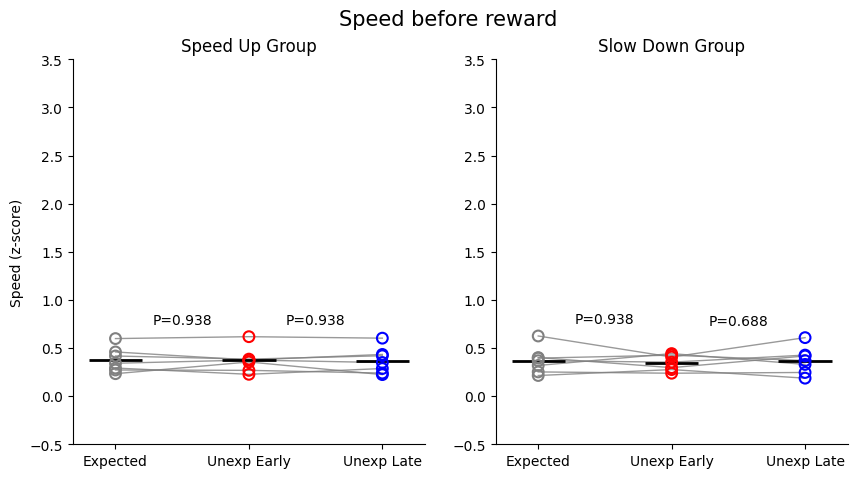

In [11]:
# Speed in acc group before reward three points plot

from scipy.stats import friedmanchisquare
from scipy.stats import wilcoxon

results = []  # each item in the result is [expected, unexpected_early, unexpected_late]
for ani in acc_group:
    avg_speed_exp_B = np.mean(np.mean(data[ani]['speed'][exp_rw[ani][20:27]][:,15:25],axis=0),axis=0)
    avg_speed_unexp_X = np.mean(np.mean(data[ani]['speed'][unexp_rw[ani][:7]][:,15:25],axis=0),axis=0)
    avg_speed_exp_X = np.mean(np.mean(data[ani]['speed'][unexp_rw[ani][20:27]][:,15:25],axis=0),axis=0)
    results.append([avg_speed_exp_B, avg_speed_unexp_X, avg_speed_exp_X])
results = np.array(results)   # shape = (n_animals, 3)
colors = ['gray', 'red', 'blue']
x_positions = [1,2,3]
fig, ax = plt.subplots(1,2,figsize=(10,5))
for i, xpos in enumerate(x_positions):
    ax[0].scatter(np.full(results.shape[0], xpos), results[:, i], facecolors='none', edgecolors=colors[i], s=60, linewidth=1.5, zorder=3) # Plot scatter points for each animal
for animal in results:
    ax[0].plot(x_positions, animal, color='gray', linewidth=1, alpha=0.8, zorder=2) # Connect each animal's points with a line
for i in range(results.shape[1]):
    mean_val = np.mean(results[:, i])
    ax[0].hlines(mean_val, i+0.8, i+1.2, colors=colors[i], linewidth=2, color = 'black') # Plot mean horizontal lines
ax[0].set_ylim([-0.5,3.5])
ax[0].set_xticks([1, 2, 3])
ax[0].set_xticklabels(['Expected', 'Unexp Early', 'Unexp Late'])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
# pairwise test
pairs = [(0,1), (0,2), (1,2)]
labels = ["Expected vs Unexp Early", "Expected vs Unexp Late", "Unexp Early vs Unexp Late"]
pvals = []
for (i,j), label in zip(pairs, labels):
    stat, p = wilcoxon(results[:,i], results[:,j])
    pvals.append(p)
# Add p value bar
i, j = 0, 1 
x = (i+1 + j+1) / 2 
y = max(results[:,i].max(), results[:,j].max()) + 0.1
ax[0].text(x, y, f"P={pvals[0]:.3f}", ha='center', va='bottom')
i, j = 1, 2 
x = (i+1 + j+1) / 2 
y = max(results[:,i].max(), results[:,j].max()) + 0.1  
ax[0].text(x, y, f"P={pvals[2]:.3f}", ha='center', va='bottom')
ax[0].set_title('Speed Up Group')
ax[0].set_ylabel("Speed (z-score)")


results = []  # each item in the result is [expected, unexpected_early, unexpected_late]
for ani in dec_group:
    avg_speed_exp_B = np.mean(np.mean(data[ani]['speed'][exp_rw[ani][20:27]][:,15:25],axis=0),axis=0)
    avg_speed_unexp_X = np.mean(np.mean(data[ani]['speed'][unexp_rw[ani][:7]][:,15:25],axis=0),axis=0)
    avg_speed_exp_X = np.mean(np.mean(data[ani]['speed'][unexp_rw[ani][20:27]][:,15:25],axis=0),axis=0)
    results.append([avg_speed_exp_B, avg_speed_unexp_X, avg_speed_exp_X])
results = np.array(results)   # shape = (n_animals, 3)
colors = ['gray', 'red', 'blue']
x_positions = [1,2,3]
for i, xpos in enumerate(x_positions):
    ax[1].scatter(np.full(results.shape[0], xpos), results[:, i], facecolors='none', edgecolors=colors[i], s=60, linewidth=1.5, zorder=3) # Plot scatter points for each animal
for animal in results:
    ax[1].plot(x_positions, animal, color='gray', linewidth=1, alpha=0.8, zorder=2) # Connect each animal's points with a line
for i in range(results.shape[1]):
    mean_val = np.mean(results[:, i])
    ax[1].hlines(mean_val, i+0.8, i+1.2, colors=colors[i], linewidth=2, color = 'black') # Plot mean horizontal lines
ax[1].set_ylim([-0.5,3.5])
ax[1].set_xticks([1, 2, 3])
ax[1].set_xticklabels(['Expected', 'Unexp Early', 'Unexp Late'])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
# pairwise test
pairs = [(0,1), (0,2), (1,2)]
labels = ["Expected vs Unexp Early", "Expected vs Unexp Late", "Unexp Early vs Unexp Late"]
pvals = []
for (i,j), label in zip(pairs, labels):
    stat, p = wilcoxon(results[:,i], results[:,j])
    pvals.append(p)
# Add p value bar
i, j = 0, 1 
x = (i+1 + j+1) / 2 
y = max(results[:,i].max(), results[:,j].max()) + 0.1
ax[1].text(x, y, f"P={pvals[0]:.3f}", ha='center', va='bottom')
i, j = 1, 2 
x = (i+1 + j+1) / 2 
y = max(results[:,i].max(), results[:,j].max()) + 0.1  
ax[1].text(x, y, f"P={pvals[2]:.3f}", ha='center', va='bottom')
ax[1].set_title('Slow Down Group')

fig.suptitle('Speed before reward', fontsize = 15)
plt.tight_layout
plt.show()

Friedman test: p = 0.2573951420525706
Expected vs Unexp Early Wilcoxon p = 0.0245361328125
Expected vs Unexp Late Wilcoxon p = 0.216552734375
Unexp Early vs Unexp Late Wilcoxon p = 0.855224609375


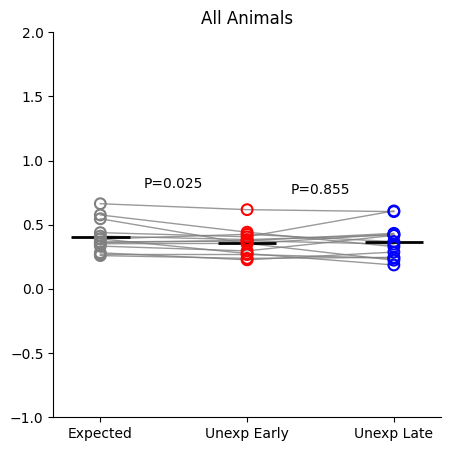

In [12]:
# Speed in acc group before reward three points plot

results = []  # each item in the result is [expected, unexpected_early, unexpected_late]
for ani in data:
    results.append([np.mean(np.mean(data[ani]['speed'][exp_rw[ani][:7]][:,15:25],axis=0),axis=0), np.mean(np.mean(data[ani]['speed'][unexp_rw[ani][:7]][:,15:25],axis=0),axis=0), np.mean(np.mean(data[ani]['speed'][unexp_rw[ani][20:27]][:,15:25],axis=0),axis=0)])
results = np.array(results)   # shape = (n_animals, 3)

colors = ['gray', 'red', 'blue']
x_positions = [1,2,3]
fig, ax = plt.subplots(1,1,figsize=(5,5))
for i, xpos in enumerate(x_positions):
    ax.scatter(np.full(results.shape[0], xpos), results[:, i], facecolors='none', edgecolors=colors[i], s=60, linewidth=1.5, zorder=3) # Plot scatter points for each animal
for animal in results:
    ax.plot(x_positions, animal, color='gray', linewidth=1, alpha=0.8, zorder=2) # Connect each animal's points with a line
for i in range(results.shape[1]):
    mean_val = np.mean(results[:, i])
    ax.hlines(mean_val, i+0.8, i+1.2, colors=colors[i], linewidth=2, color = 'black') # Plot mean horizontal lines
ax.set_ylim([-1,2])
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['Expected', 'Unexp Early', 'Unexp Late'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Calculate P values
stat, p = friedmanchisquare(results[:,0], results[:,1], results[:,2])
print("Friedman test:" , "p =", p)
# pairwise test
pairs = [(0,1), (0,2), (1,2)]
labels = ["Expected vs Unexp Early", "Expected vs Unexp Late", "Unexp Early vs Unexp Late"]
pvals = []
for (i,j), label in zip(pairs, labels):
    stat, p = wilcoxon(results[:,i], results[:,j])
    pvals.append(p)
    print(label, "Wilcoxon p =", p)

# Add p value bar
i, j = 0, 1 
x = (i+1 + j+1) / 2 
y = max(results[:,i].max(), results[:,j].max()) + 0.1
ax.text(x, y, f"P={pvals[0]:.3f}", ha='center', va='bottom')
i, j = 1, 2 
x = (i+1 + j+1) / 2 
y = max(results[:,i].max(), results[:,j].max()) + 0.1  
ax.text(x, y, f"P={pvals[2]:.3f}", ha='center', va='bottom')
ax.set_title('All Animals')

plt.tight_layout
plt.show()

Friedman test: p = 0.39511776132688653
Expected vs Unexp Early Wilcoxon p = 0.267578125
Expected vs Unexp Late Wilcoxon p = 0.2957763671875
Unexp Early vs Unexp Late Wilcoxon p = 0.13525390625
Friedman test: p = 0.02437284407327975
Expected vs Unexp Early Wilcoxon p = 0.2412109375
Expected vs Unexp Late Wilcoxon p = 0.0040283203125
Unexp Early vs Unexp Late Wilcoxon p = 0.5015869140625


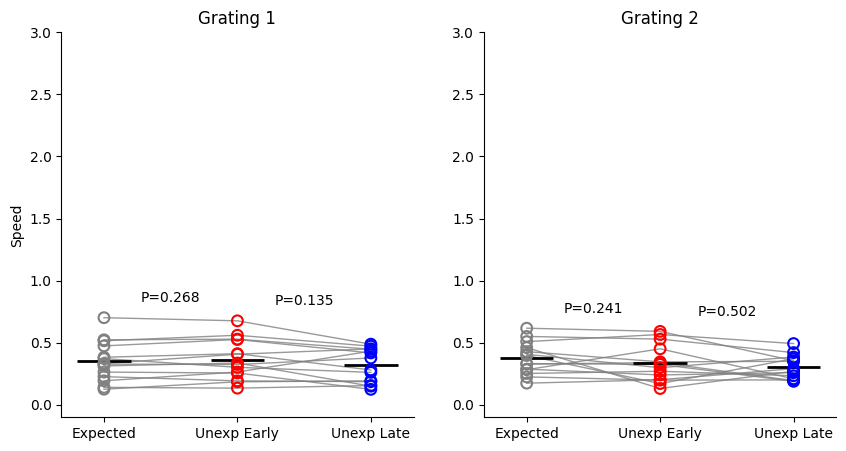

In [13]:
# Speed in all animals near the two gratings three points plot

from scipy.stats import friedmanchisquare
from scipy.stats import wilcoxon

unexp_grat = {}
exp_grat = {}
for ani in data:
    unexp_grat[ani] = []
    exp_grat[ani] = []
    for trial in data[ani]['unpred_trials']['gr_2']:
        unexp_grat[ani].append(range(data[ani]['grating_indices']['gr_1'][trial]-25,data[ani]['grating_indices']['gr_1'][trial]+55))
    for trial in data[ani]['unpred_trials']['gr_2']:
        exp_grat[ani].append(range(data[ani]['grating_indices']['gr_1'][trial-1]-25,data[ani]['grating_indices']['gr_1'][trial-1]+55))

results = []  # each item in the result is [expected, unexpected_early, unexpected_late]
for ani in data:
    results.append([np.mean(np.mean(data[ani]['speed'][exp_grat[ani][:7]][:,25:45],axis=0),axis=0), np.mean(np.mean(data[ani]['speed'][unexp_grat[ani][:7]][:,25:45],axis=0),axis=0), np.mean(np.mean(data[ani]['speed'][unexp_grat[ani][20:27]][:,25:45],axis=0),axis=0)])
results = np.array(results)   # shape = (n_animals, 3)
colors = ['gray', 'red', 'blue']
x_positions = [1,2,3]
fig, ax = plt.subplots(1,2,figsize=(10,5))
for i, xpos in enumerate(x_positions):
    ax[0].scatter(np.full(results.shape[0], xpos), results[:, i], facecolors='none', edgecolors=colors[i], s=60, linewidth=1.5, zorder=3) # Plot scatter points for each animal
for animal in results:
    ax[0].plot(x_positions, animal, color='gray', linewidth=1, alpha=0.8, zorder=2) # Connect each animal's points with a line
for i in range(results.shape[1]):
    mean_val = np.mean(results[:, i])
    ax[0].hlines(mean_val, i+0.8, i+1.2, colors=colors[i], linewidth=2, color = 'black') # Plot mean horizontal lines
ax[0].set_ylim([-0.1,3])
ax[0].set_xticks([1, 2, 3])
ax[0].set_xticklabels(['Expected', 'Unexp Early', 'Unexp Late'])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

# Calculate P values
stat, p = friedmanchisquare(results[:,0], results[:,1], results[:,2])
print("Friedman test:" , "p =", p)
# pairwise test
pairs = [(0,1), (0,2), (1,2)]
labels = ["Expected vs Unexp Early", "Expected vs Unexp Late", "Unexp Early vs Unexp Late"]
pvals = []
for (i,j), label in zip(pairs, labels):
    stat, p = wilcoxon(results[:,i], results[:,j])
    pvals.append(p)
    print(label, "Wilcoxon p =", p)
# Add p value bar
i, j = 0, 1 
x = (i+1 + j+1) / 2 
y = max(results[:,i].max(), results[:,j].max()) + 0.1
ax[0].text(x, y, f"P={pvals[0]:.3f}", ha='center', va='bottom')
i, j = 1, 2 
x = (i+1 + j+1) / 2 
y = max(results[:,i].max(), results[:,j].max()) + 0.1  
ax[0].text(x, y, f"P={pvals[2]:.3f}", ha='center', va='bottom')
ax[0].set_title('Grating 1')
ax[0].set_ylabel('Speed')


unexp_grat = {}
exp_grat = {}
for ani in data:
    unexp_grat[ani] = []
    exp_grat[ani] = []
    for trial in data[ani]['unpred_trials']['gr_2']:
        unexp_grat[ani].append(range(data[ani]['grating_indices']['gr_2'][trial]-25,data[ani]['grating_indices']['gr_2'][trial]+55))
    for trial in data[ani]['unpred_trials']['gr_2']:
        exp_grat[ani].append(range(data[ani]['grating_indices']['gr_2'][trial-1]-25,data[ani]['grating_indices']['gr_2'][trial-1]+55))
results = []  # each item in the result is [expected, unexpected_early, unexpected_late]
for ani in data:
    results.append([np.mean(np.mean(data[ani]['speed'][exp_grat[ani][:7]][:,25:45],axis=0),axis=0), np.mean(np.mean(data[ani]['speed'][unexp_grat[ani][:7]][:,25:45],axis=0),axis=0), np.mean(np.mean(data[ani]['speed'][unexp_grat[ani][20:27]][:,25:45],axis=0),axis=0)])
results = np.array(results)   # shape = (n_animals, 3)

colors = ['gray', 'red', 'blue']
x_positions = [1,2,3]
for i, xpos in enumerate(x_positions):
    ax[1].scatter(np.full(results.shape[0], xpos), results[:, i], facecolors='none', edgecolors=colors[i], s=60, linewidth=1.5, zorder=3) # Plot scatter points for each animal
for animal in results:
    ax[1].plot(x_positions, animal, color='gray', linewidth=1, alpha=0.8, zorder=2) # Connect each animal's points with a line
for i in range(results.shape[1]):
    mean_val = np.mean(results[:, i])
    ax[1].hlines(mean_val, i+0.8, i+1.2, colors=colors[i], linewidth=2, color = 'black') # Plot mean horizontal lines
ax[1].set_ylim([-0.1,3])
ax[1].set_xticks([1, 2, 3])
ax[1].set_xticklabels(['Expected', 'Unexp Early', 'Unexp Late'])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

# Calculate P values
stat, p = friedmanchisquare(results[:,0], results[:,1], results[:,2])
print("Friedman test:" , "p =", p)
# pairwise test
pairs = [(0,1), (0,2), (1,2)]
labels = ["Expected vs Unexp Early", "Expected vs Unexp Late", "Unexp Early vs Unexp Late"]
pvals = []
for (i,j), label in zip(pairs, labels):
    stat, p = wilcoxon(results[:,i], results[:,j])
    pvals.append(p)
    print(label, "Wilcoxon p =", p)
# Add p value bar
i, j = 0, 1 
x = (i+1 + j+1) / 2 
y = max(results[:,i].max(), results[:,j].max()) + 0.1
ax[1].text(x, y, f"P={pvals[0]:.3f}", ha='center', va='bottom')
i, j = 1, 2 
x = (i+1 + j+1) / 2 
y = max(results[:,i].max(), results[:,j].max()) + 0.1  
ax[1].text(x, y, f"P={pvals[2]:.3f}", ha='center', va='bottom')
ax[1].set_title('Grating 2')
plt.tight_layout
plt.show()

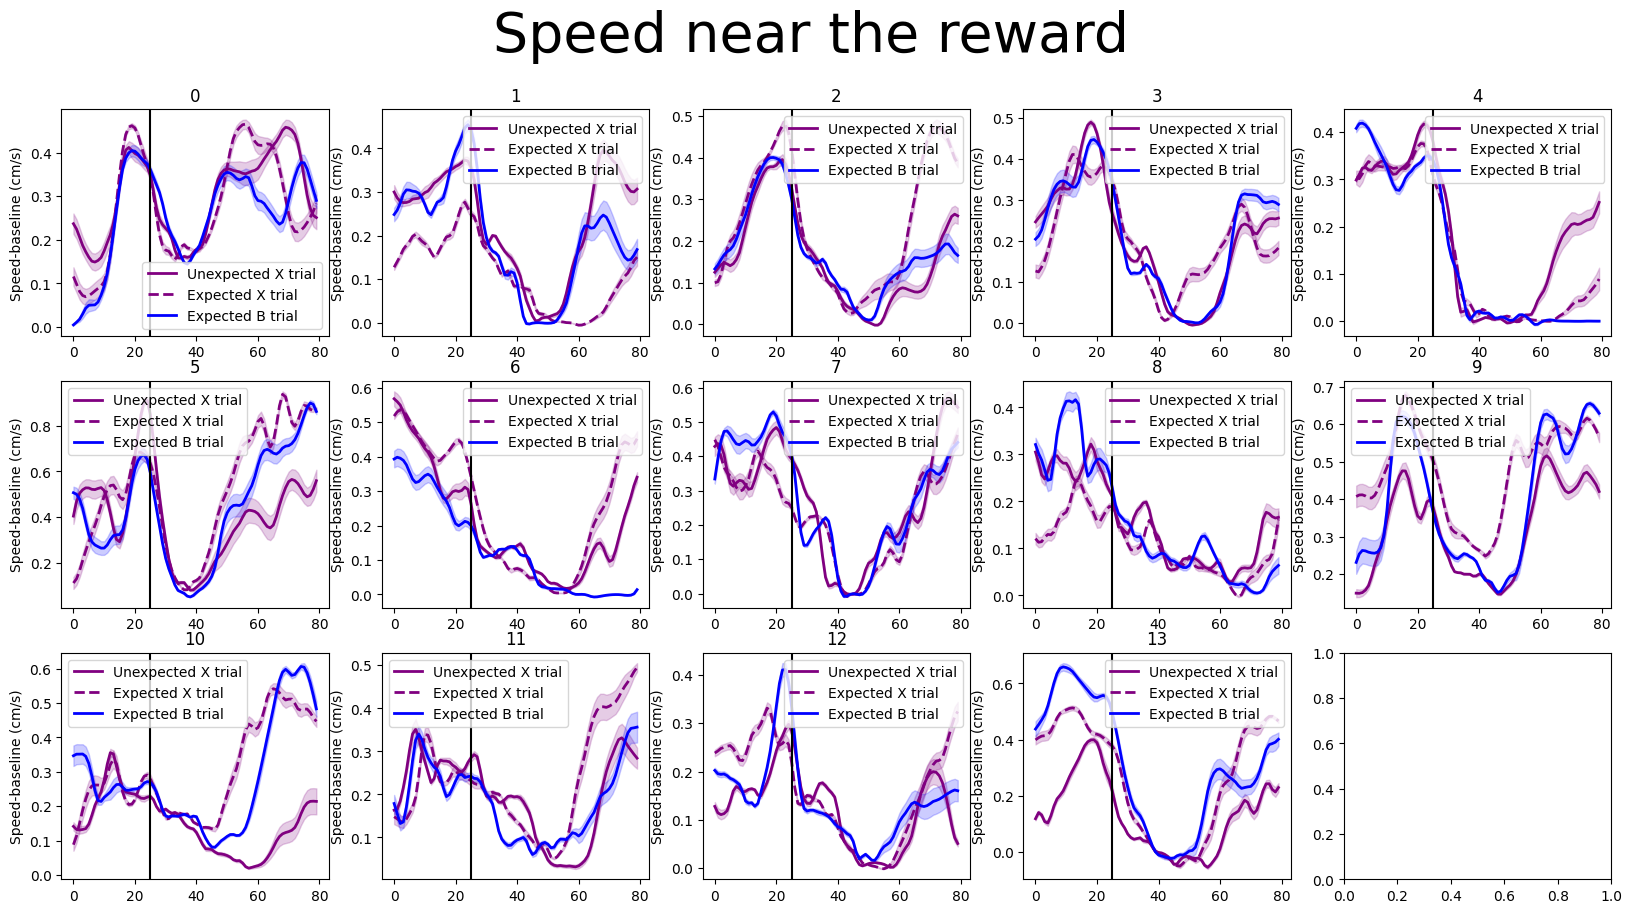

In [14]:
# SPEED NEAR THE REWARD FOR EACH ANIMAL

unexp_rw = {}
exp_rw = {}
for ani in data:
    unexp_rw[ani] = []
    exp_rw[ani] = []
    for trial in data[ani]['unpred_trials']['gr_2']:
        if trial < data[ani]['reward_indices'].shape[0]:    # index out of range,,, so
            unexp_rw[ani].append(range(data[ani]['reward_indices'][trial]-25,data[ani]['reward_indices'][trial]+55)) 
    for trial in data[ani]['unpred_trials']['gr_2']:
        if trial < data[ani]['reward_indices'].shape[0]:
            exp_rw[ani].append(range(data[ani]['reward_indices'][trial-1]-25,data[ani]['reward_indices'][trial-1]+55))

fig, axes = plt.subplots(3, 5, figsize=(20, 10)) 
fig.suptitle('Speed near the reward', fontsize = 40)
t_frames = range(80)
for i, ani in enumerate(data):
    row = i // 5
    col = i % 5
    ax = axes[row, col]
    af.plot_shaded_error(ax, t_frames, data[ani]['speed'][np.array(unexp_rw[ani][:7])], color='purple', alpha=0.2, label='Unexpected X trial')
    af.plot_shaded_error(ax, t_frames, data[ani]['speed'][np.array(unexp_rw[ani][20:27])], color='purple', alpha=0.2, style='dash', label='Expected X trial')
    af.plot_shaded_error(ax, t_frames, data[ani]['speed'][np.array(exp_rw[ani][7:14])], color='blue', alpha=0.2, label= 'Expected B trial')
    ax.axvline([25], color='black')
    ax.set_ylabel('Speed-baseline (cm/s)')
    ax.set_title(f'{ani}')
    ax.legend()

In [15]:
# Fit the speed prior to reward with polynomial curve and calculate the acceleration

deg = 6

poly_fit_speed_unexp = {}
for ani in data:
    poly_fit_speed_unexp[ani] = []
    for index in unexp_rw[ani]: 
        y = data[ani]['speed'][index[:25]]
        x = np.arange(len(y))
        coeffs = np.polyfit(x, y, deg)
        poly = np.poly1d(coeffs)
        poly_fit_speed_unexp[ani].append(poly(x))

poly_fit_speed_exp = {}
for ani in data:
    poly_fit_speed_exp[ani] = []
    for index in exp_rw[ani]:
        y = data[ani]['speed'][index[:25]]
        x = np.arange(len(y))
        coeffs = np.polyfit(x, y, deg)
        poly = np.poly1d(coeffs)
        poly_fit_speed_exp[ani].append(poly(x))    

[ 5.43771719e-08  4.03273822e-06 -3.53033361e-04  7.59767111e-03
 -5.66007598e-02  7.95916403e-02  4.51379295e-01]


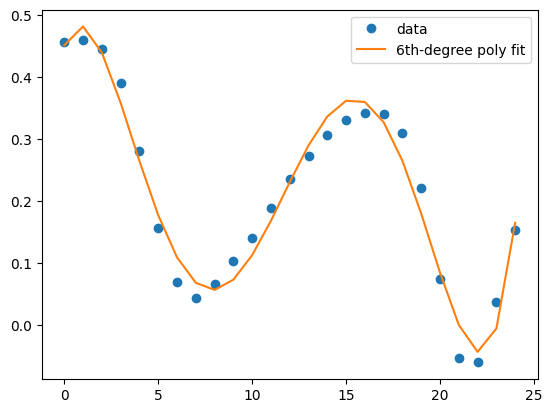

In [16]:
y = data[ani]['speed'][unexp_rw[0][12]][:25]
x = range(len(y))
coeffs = np.polyfit(x, y, deg=6)
poly   = np.poly1d(coeffs)
print(coeffs)
plt.plot(x, y, 'o', label='data')
plt.plot(x, poly(x), '-', label='6th-degree poly fit')
plt.legend()
plt.show()

Text(0.5, 0.98, 'Acceleration Near Reward')

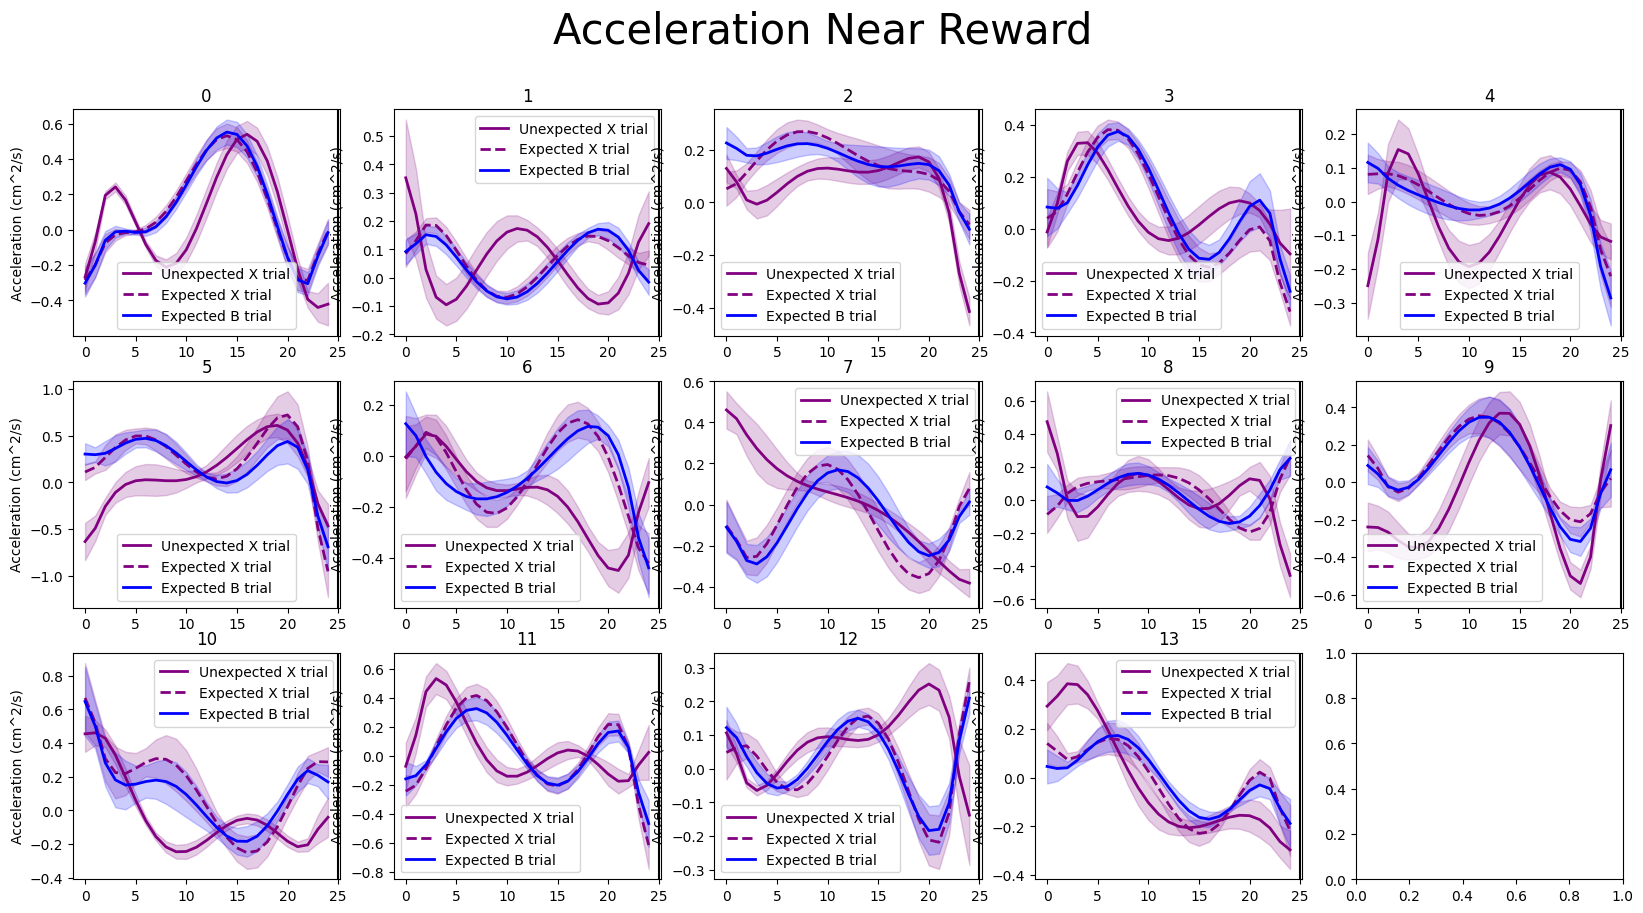

In [17]:
# acceleration/deceleration prior to reward to each animal

fig, axes = plt.subplots(3, 5, figsize=(20, 10)) 
t_frames = range(25)
for i, ani in enumerate(data):
    row = i // 5
    col = i % 5
    ax = axes[row, col]
    af.plot_shaded_error(ax, t_frames, np.gradient(poly_fit_speed_exp[ani],0.1,axis = 1)[:7], color='purple', alpha=0.2, label='Unexpected X trial')
    af.plot_shaded_error(ax, t_frames, np.gradient(poly_fit_speed_exp[ani],0.1,axis = 1)[20:27], color='purple', alpha=0.2, style='dash', label='Expected X trial')
    af.plot_shaded_error(ax, t_frames, np.gradient(poly_fit_speed_unexp[ani],0.1,axis = 1)[20:27], color='blue', alpha=0.2, label= 'Expected B trial')
    ax.set_title(f'{ani}')
    ax.axvline([25], color = 'black')
    ax.set_ylabel('Acceleration (cm^2/s)')
    ax.legend()
fig.suptitle('Acceleration Near Reward', fontsize=30)

Text(0.5, 0.98, 'Acceleration Before Reward')

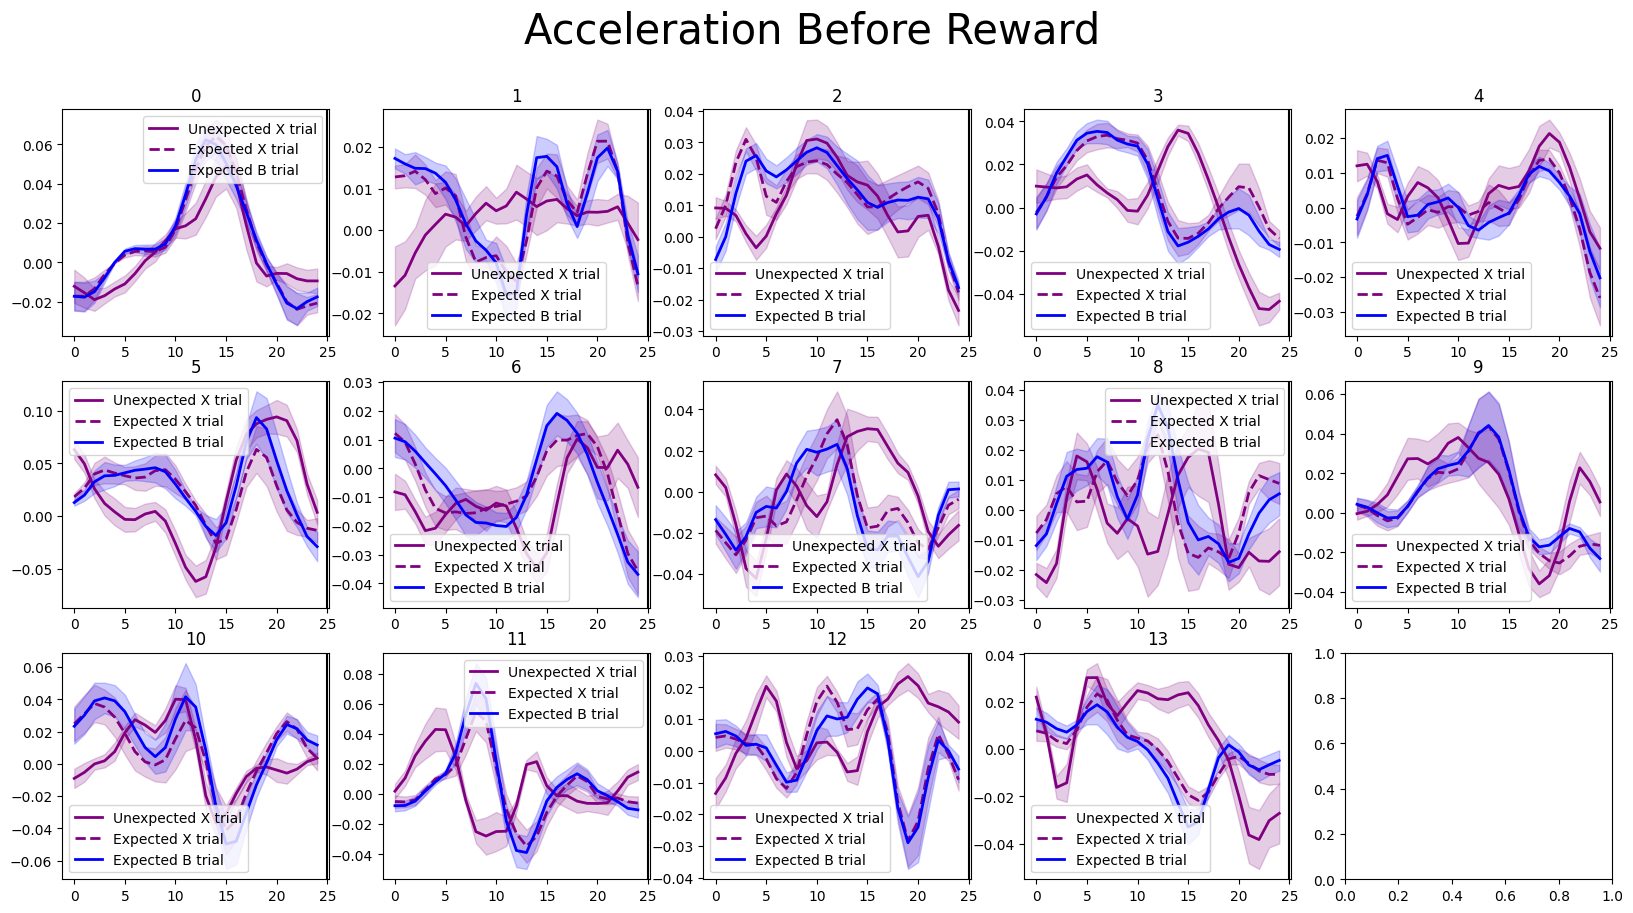

In [18]:
# acceleration/deceleration prior to reward to each animal

fig, axes = plt.subplots(3, 5, figsize=(20, 10)) 
t_frames = range(25)
for i, ani in enumerate(data):
    row = i // 5
    col = i % 5
    ax = axes[row, col]
    af.plot_shaded_error(ax, t_frames, np.gradient(data[ani]['speed'][np.array(unexp_rw[ani])][:,:25],axis = 1)[:7], color='purple', alpha=0.2, label='Unexpected X trial')
    af.plot_shaded_error(ax, t_frames, np.gradient(data[ani]['speed'][np.array(unexp_rw[ani])][:,:25],axis = 1)[20:27], color='purple', alpha=0.2, style='dash', label='Expected X trial')
    af.plot_shaded_error(ax, t_frames, np.gradient(data[ani]['speed'][np.array(exp_rw[ani])][:,:25],axis = 1)[20:27], color='blue', alpha=0.2, label= 'Expected B trial')
    ax.set_title(f'{ani}')
    ax.axvline([25], color = 'black')
    ax.legend()
fig.suptitle('Acceleration Before Reward', fontsize=30)

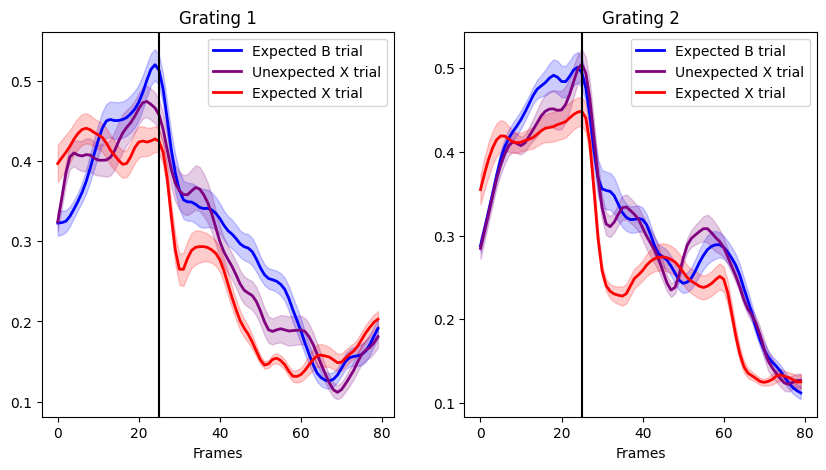

In [19]:
# Speed at gratings averaged over all animals

fig,axes = plt.subplots(1,2,figsize=(10,5))

unexp_grat = {}
exp_grat = {}
for ani in data:
    unexp_grat[ani] = []
    exp_grat[ani] = []
    for trial in data[ani]['unpred_trials']['gr_2']:
        unexp_grat[ani].append(range(data[ani]['grating_indices']['gr_1'][trial]-25,data[ani]['grating_indices']['gr_1'][trial]+55))
    for trial in data[ani]['unpred_trials']['gr_2']:
        exp_grat[ani].append(range(data[ani]['grating_indices']['gr_1'][trial-1]-25,data[ani]['grating_indices']['gr_1'][trial-1]+55))
af.plot_shaded_error(axes[0], range(80), np.mean(np.stack([data[ani]['speed'][exp_grat[ani][:7]] for ani in acc_group]), axis = 1),color='blue', alpha=0.2, label= 'Expected B trial')
af.plot_shaded_error(axes[0], range(80), np.mean(np.stack([data[ani]['speed'][unexp_grat[ani][:7]] for ani in acc_group]), axis = 1) ,color='purple', alpha=0.2,label = 'Unexpected X trial')
af.plot_shaded_error(axes[0], range(80), np.mean(np.stack([data[ani]['speed'][unexp_grat[ani][20:27]] for ani in acc_group]), axis = 1),color='red', alpha=0.2,label= 'Expected X trial')
axes[0].set_title('Grating 1')
axes[0].axvline(25, color='black')
axes[0].set_xlabel('Frames')
axes[0].legend()

unexp_grat = {}
exp_grat = {}
for ani in data:
    unexp_grat[ani] = []
    exp_grat[ani] = []
    for trial in data[ani]['unpred_trials']['gr_2']:
        unexp_grat[ani].append(range(data[ani]['grating_indices']['gr_2'][trial]-25,data[ani]['grating_indices']['gr_2'][trial]+55))
    for trial in data[ani]['unpred_trials']['gr_2']:
        exp_grat[ani].append(range(data[ani]['grating_indices']['gr_2'][trial-1]-25,data[ani]['grating_indices']['gr_2'][trial-1]+55))
af.plot_shaded_error(axes[1], range(80), np.mean(np.stack([data[ani]['speed'][exp_grat[ani][:7]] for ani in acc_group]), axis = 1),color='blue', alpha=0.2, ylim = 0,  label= 'Expected B trial')
af.plot_shaded_error(axes[1], range(80), np.mean(np.stack([data[ani]['speed'][unexp_grat[ani][:7]] for ani in acc_group]), axis = 1) ,color='purple', alpha=0.2,label = 'Unexpected X trial')
af.plot_shaded_error(axes[1], range(80), np.mean(np.stack([data[ani]['speed'][unexp_grat[ani][20:27]] for ani in acc_group]), axis = 1),color='red', alpha=0.2,label= 'Expected X trial')
axes[1].set_title('Grating 2')
axes[1].axvline(25, color='black')
axes[1].set_xlabel('Frames')
axes[1].legend()

In [20]:
# Hypothesis: the mean speed before the reward is higher in expected trials than unexpected trials

#   B trials > U trials : P value 0.001

# speeds = {}

# for ani in data:
#     expected_B = []
#     expected_X = []
#     unexpected_X = []
#     expected_B = data[ani]['speed'][np.array(exp_rw[ani][:7])]
#     expected_X = data[ani]['speed'][np.array(unexp_rw[ani][20:27])]
#     unexpected_X = data[ani]['speed'][np.array(unexp_rw[ani][:7])]
#     speeds[ani] = np.concatenate(np.array([expected_B, expected_X, unexpected_X]))

# speeds = np.stack([speeds[ani] for ani in data]) 

# # speeds shape: (animals, (7 expected_B + 7 expected_X + 7 unexpected_X), timepoints)

# n_bootstraps = 1000
# null_diffs = np.zeros(n_bootstraps) 
# mean_B = np.mean(np.mean(np.mean(speeds[:, 0:7, :25], axis=0), axis=0), axis = 0)
# mean_X = np.mean(np.mean(np.mean(speeds[:, 7:14, :25], axis=0), axis=0), axis = 0)
# mean_U = np.mean(np.mean(np.mean(speeds[:, 14:21, :25], axis=0), axis=0), axis = 0)
# # observed_diffs =  min(mean_B - mean_X, mean_X - mean_U)
# observed_diffs = mean_B - mean_U

# for i in range(n_bootstraps):
#     shuffled_labels = np.random.permutation(speeds.shape[1]) # shuffle the three conditions
#     shuffled_mean_B = np.mean(np.mean(np.mean(speeds[:, shuffled_labels[0:7], :25], axis=0), axis=0), axis = 0)
#     shuffled_mean_X = np.mean(np.mean(np.mean(speeds[:, shuffled_labels[7:14], :25], axis=0), axis=0), axis = 0)
#     shuffled_mean_U = np.mean(np.mean(np.mean(speeds[:, shuffled_labels[14:21], :25], axis=0), axis=0), axis = 0)
#     # null_diffs[i] = min(shuffled_mean_B - shuffled_mean_X, shuffled_mean_X - shuffled_mean_U)
#     null_diffs[i] = shuffled_mean_B - shuffled_mean_U

# p_value = np.mean(null_diffs >= observed_diffs)
# print("Observed means:", mean_B, mean_X, mean_U)
# print("Observed stat:", observed_diffs)
# print("p-value:", p_value)

KeyError: 'activity'

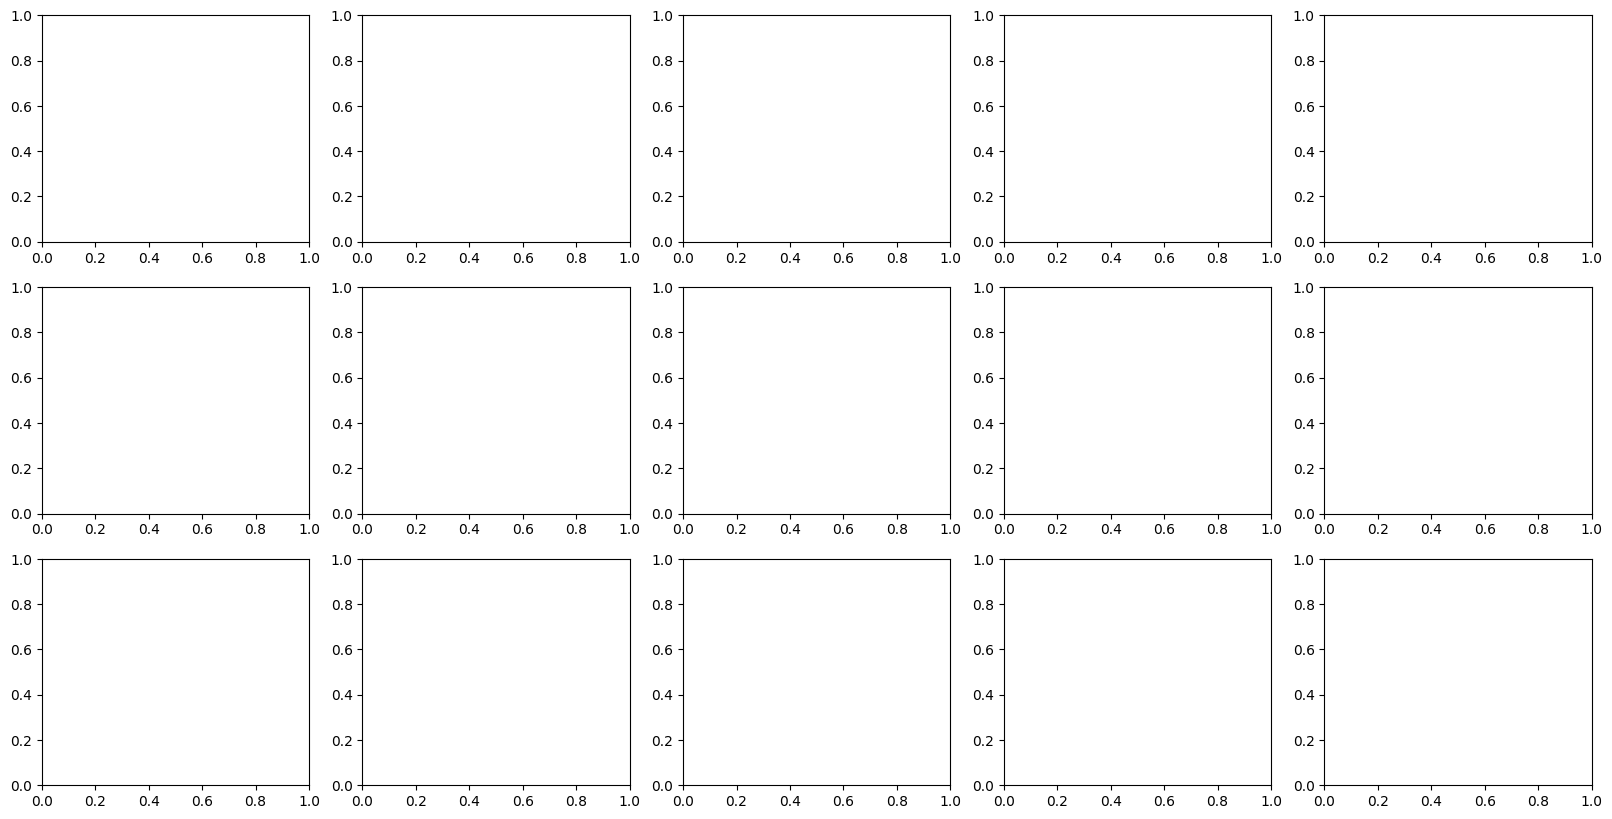

In [21]:
# Speed in grating 2 for each animal

unexp_tr = {}
exp_tr = {}
unexp_grat = {}
exp_grat = {}
for ani in data:
    unexp_grat[ani] = []
    exp_grat[ani] = []
    unexp_tr[ani] = []
    exp_tr[ani] = []
    for trial in data[ani]['unpred_trials']['gr_2']:
        unexp_grat[ani].append(data[ani]['grating_indices']['gr_2'][trial])
    for trial in data[ani]['unpred_trials']['gr_2']:
        exp_grat[ani].append(data[ani]['grating_indices']['gr_2'][trial-1])

fig, axes = plt.subplots(3, 5, figsize=(20, 10))
t_frames = data[ani]['activity']['gr_2'].shape[2]
for i, ani in enumerate(data):
    row = i // 5
    col = i % 5
    ax = axes[row, col] 
    af.plot_shaded_error(ax, range(t_frames), data[ani]['speed'][unexp_grat[ani][:7]], color='purple', alpha=0.2, label='Unexpected X trial')
    af.plot_shaded_error(ax, range(t_frames), data[ani]['speed'][unexp_grat[ani][20:28]], color='purple', alpha=0.2, style='dash', label='Expected X trial')
    af.plot_shaded_error(ax, range(t_frames), data[ani]['speed'][exp_grat[ani][:15]], color='blue', alpha=0.2, label= 'Expected B trial')
    ax.axvline(x=20, color='gray', linestyle='--', linewidth=1)
    ax.set_title(f'{ani}')
    ax.legend()
    


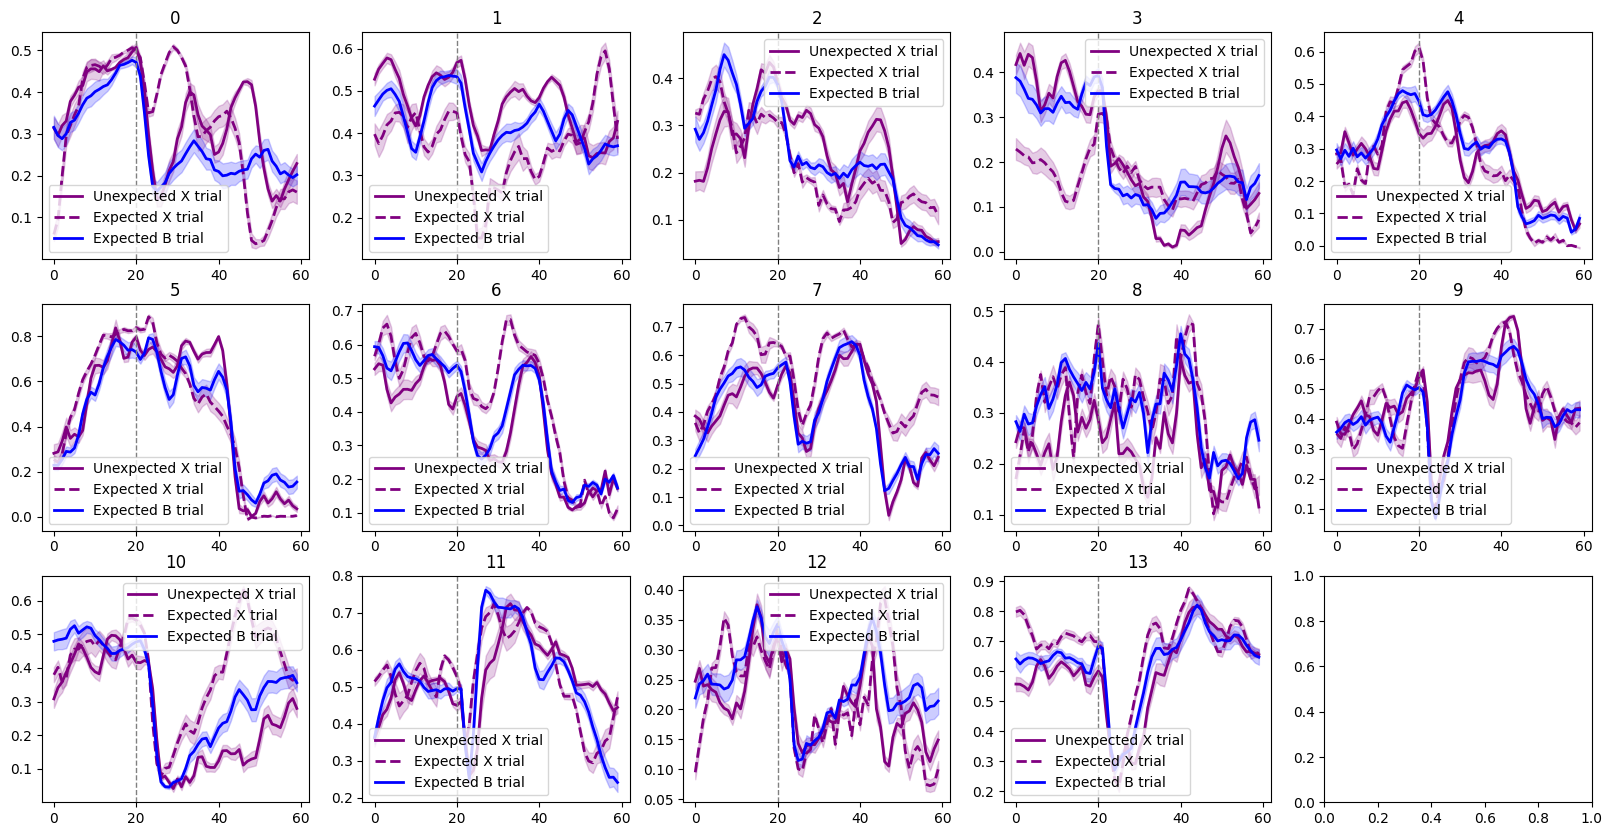

In [ ]:
# Speed in grating 1 for each animal

unexp_tr = {}
exp_tr = {}
unexp_grat = {}
exp_grat = {}
for ani in data:
    unexp_grat[ani] = []
    exp_grat[ani] = []
    unexp_tr[ani] = []
    exp_tr[ani] = []
    for trial in data[ani]['pred_trials']:
        unexp_grat[ani].append(data[ani]['grating_indices']['gr_1'][trial])
    for trial in data[ani]['pred_trials']:
        exp_grat[ani].append(data[ani]['grating_indices']['gr_1'][trial+2])

fig, axes = plt.subplots(3, 5, figsize=(20, 10))
t_frames = data[ani]['activity']['gr_1'].shape[2]
for i, ani in enumerate(data):
    row = i // 5
    col = i % 5
    ax = axes[row, col] 
    af.plot_shaded_error(ax, range(t_frames), data[ani]['speed'][unexp_grat[ani][:7]], color='purple', alpha=0.2, label='Unexpected X trial')
    af.plot_shaded_error(ax, range(t_frames), data[ani]['speed'][unexp_grat[ani][20:28]], color='purple', alpha=0.2, style='dash', label='Expected X trial')
    af.plot_shaded_error(ax, range(t_frames), data[ani]['speed'][exp_grat[ani][:15]], color='blue', alpha=0.2, label= 'Expected B trial')
    ax.axvline(x=20, color='gray', linestyle='--', linewidth=1)
    ax.set_title(f'{ani}')
    ax.legend()
    